Using TF 1.14 and Keras 2.2.4 - there are warnings but TF 2+ is difficult with Windows :/

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.
C:\Users\Chloe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Chloe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Chloe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Chloe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [36]:
data = pd.read_csv('utterance-data-with-labels-binary.csv')

In [37]:
data.head()

,ObsID,UtteranceID,TeacherID,TranscribedUtterance,IsQuestion,IsInstructionalUtterance,IsInstructionalStatement,IsDisciplinaryUtterance,IsDisciplinaryStatement,IsEvaluationFollowupIncluded,...,CombinedAuthCogUptake,CogLevel,Uptake,IsGoalSpecified,IsDisciplinaryTermsPresent,IsInstructionalQuestion,IsDisciplinaryQuestion,IsStudentResponsePresent,Authenticity,IsSerialQuestion
0,sch01_tch01_03_19_18_period03,1,sch01_tch01,oh you mean the,1,1,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
1,sch01_tch01_03_19_18_period03,101,sch01_tch01,thank you somebody,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,sch01_tch01_03_19_18_period03,102,sch01_tch01,so I'll need some some help reading it,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,sch01_tch01_03_19_18_period03,103,sch01_tch01,you will have died from walking across the str...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,sch01_tch01_03_19_18_period03,104,sch01_tch01,get a very good soil goes into like that aware...,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [38]:
utterances = data['TranscribedUtterance']

**Variables to include:** 'IsInstructionalUtterance', 'IsQuestion', 'Authenticity', 'IsEvaluationElaborated', 'CogLevel', 'IsGoalSpecified', 'IsDisciplinaryTermsPresent'

In [39]:
data = data.drop(['IsInstructionalStatement','IsDisciplinaryUtterance','IsDisciplinaryStatement','IsEvaluationFollowupIncluded','IsEvaluationValencePositive','CombinedAuthCogUptake','Uptake','IsInstructionalQuestion', 'IsDisciplinaryQuestion','IsStudentResponsePresent','IsSerialQuestion'], axis=1)

In [40]:
data.columns

Index(['ObsID', 'UtteranceID', 'TeacherID', 'TranscribedUtterance',
       'IsQuestion', 'IsInstructionalUtterance', 'IsEvaluationElaborated',
       'CogLevel', 'IsGoalSpecified', 'IsDisciplinaryTermsPresent',
       'Authenticity'],
      dtype='object')

In [41]:
respList = np.array([list(data.iloc[0,4:])])
for i in range(1,len(data)):
    respList = np.append(respList, [list(data.iloc[i,4:])], axis=0)
print(respList.shape)

(16977, 7)


In [42]:
docs = list(utterances.values)

In [43]:
# tokenize
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the sequences
encoded_docs = t.texts_to_sequences(docs)

(array([1.6496e+04, 3.7400e+02, 7.6000e+01, 1.2000e+01, 6.0000e+00,
        6.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.000e+00, 1.130e+02, 2.250e+02, 3.370e+02, 4.490e+02, 5.610e+02,
        6.730e+02, 7.850e+02, 8.970e+02, 1.009e+03, 1.121e+03, 1.233e+03,
        1.345e+03, 1.457e+03, 1.569e+03, 1.681e+03, 1.793e+03, 1.905e+03,
        2.017e+03, 2.129e+03, 2.241e+03]),
 <a list of 20 Patch objects>)

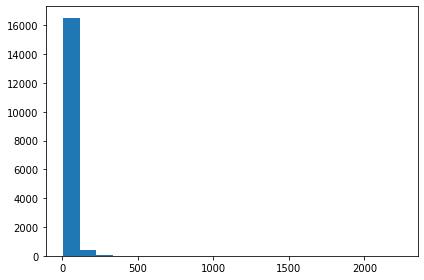

In [44]:
# find longest utterance
utterance_lengths = []
for i in range(len(encoded_docs)):
    utterance_lengths.append(len(encoded_docs[i]))

# histogram of utterance length
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, tight_layout=True)
axs.hist(utterance_lengths, bins=20)

In [45]:
# pad documents to max length
padded_docs_init = pad_sequences(encoded_docs, maxlen=max(utterance_lengths), padding='post')
# trim to 300 words
padded_docs = pad_sequences(padded_docs_init, maxlen=300, truncating='post')

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, respList, test_size=0.2)
print(X_train.shape, 'train sequences')
print(X_test.shape, 'test sequences')

(13581, 300) train sequences
(3396, 300) test sequences


In [23]:
#build model
max_features = 50000
batch_size = 32

model = Sequential()
model.add(Embedding(max_features, 128, input_length=300))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='sigmoid'))

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 128)          6400000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 903       
Total params: 6,532,487
Trainable params: 6,532,487
Non-trainable params: 0
_________________________________________________________________


In [25]:
#train model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Train...')
model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))
score, acc = model.evaluate(X_test, y_test,batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Train on 13581 samples, validate on 3396 samples
Epoch 1/5
13581/13581 [==============================] - 657s 48ms/step - loss: 0.3819 - acc: 0.8231 - val_loss: 0.3787 - val_acc: 0.8232
Epoch 2/5
13581/13581 [==============================] - 649s 48ms/step - loss: 0.3818 - acc: 0.8237 - val_loss: 0.3775 - val_acc: 0.8274
Epoch 3/5
13581/13581 [==============================] - 649s 48ms/step - loss: 0.3815 - acc: 0.8225 - val_loss: 0.3776 - val_acc: 0.8274
Epoch 4/5
13581/13581 [==============================] - 693s 51ms/step - loss: 0.3814 - acc: 0.8225 - val_loss: 0.3773 - val_acc: 0.8274
Epoch 5/5
3396/3396 [==============================] - 24s 7ms/step
Test score: 0.37703018169521024
Test accuracy: 0.8273599593602867


In [31]:
y_pred = model.predict(X_test)

In [33]:
y_pred

array([[0.30345616, 0.7981721 , 0.5198138 , ..., 0.03027797, 0.09021932,
        0.04560289],
       [0.30345616, 0.7981721 , 0.5198138 , ..., 0.03027797, 0.09021932,
        0.04560289],
       [0.30345616, 0.7981721 , 0.5198138 , ..., 0.03027797, 0.09021932,
        0.04560289],
       ...,
       [0.30345616, 0.7981721 , 0.5198138 , ..., 0.03027797, 0.09021938,
        0.04560289],
       [0.30345613, 0.7981721 , 0.5198138 , ..., 0.03027797, 0.09021938,
        0.04560289],
       [0.30345616, 0.7981721 , 0.5198138 , ..., 0.03027797, 0.09021938,
        0.04560289]], dtype=float32)

In [28]:
X_test

array([[  87,    0,    0, ...,    0,    0,    0],
       [   4,  194, 2899, ...,    0,    0,    0],
       [   9,   19,  154, ...,    0,    0,    0],
       ...,
       [ 306,   58,   20, ...,    0,    0,    0],
       [ 155,   16,  162, ...,    0,    0,    0],
       [  31,   74,   51, ...,    0,    0,    0]])